In [1]:
%pylab inline
import geopandas as gpd
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Canadian RAP Drainline Shapefile Clipping

We'll be using the [National Map 1 Million Scale Streams](https://nationalmap.gov/small_scale/mld/1strmsl.html) within the state of Alaska. It seems to be the most detailed (containing even very small streams) topologically correct representation. Specifically, it came from [here](https://nationalmap.gov/small_scale/atlasftp.html?openChapters=chpwater#chpwater) in the "Hydrographic Geodatabase - Alaska, One Million-Scale" ([download link](https://prd-tnm.s3.amazonaws.com/StagedProducts/Small-scale/data/Hydrography/hydrakm010g.gdb_nt00894.tar.gz)). It's the layer called "`hydrakm010g Stream`". However, it does not extend into Canada so it doesn't encompass the entirety of the SASAP study regions. So I want to get the RAP drainline data from the Canadian portions of the SASAP regions. That came to me,from Leslie Jones as `RAP.zip`, in two geodatabases. One for Alaska that continues into Canada for the Yukon and part of the Southeast SASAP regions, and another that has British Columbia including the other part of the Souteast region.

So I want just the Canadian part of the Alaska RAP drainlines, and just the Canadian/Southeast region part of the British Columbia rivers. Then I want to stick these two parts together with the National Map rivers. The tricky part will be attaching the river networks at the US / Canada border.

In [2]:
rap_riv_fn = '/Users/jkibele/Documents/SASAP/sasap-size-declines/RiverDistance/data/RAP/AK_RAP_DrainageLine_SO.shp'
bc_rap_riv_fn = '/Users/jkibele/Documents/SASAP/sasap-size-declines/RiverDistance/data/RAP/BC_RAP_DrainageLine_SO.shp'
canada_fn = '/Users/jkibele/Documents/SASAP/sasap-size-declines/RiverDistance/data/Canada/Canada.shp'
sasap_reg_fn = '/Users/jkibele/Documents/SASAP/gis/data_sasap/Regions Shapefile/sasap_regions_3338.shp'
# alaska_fn = '/Users/jkibele/Documents/SASAP/gis/data_ADNR/mv_alaska_simplified_py.shp'

Load in the shapefils to GeoDataFrames.

In [3]:
rivs = gpd.read_file(rap_riv_fn)
canada = gpd.read_file(canada_fn)
bc_rap_riv = gpd.read_file(bc_rap_riv_fn)

The Canada shapefile was in a different projection, so I'll reproject it to match my other data (EPSG 3338 - Alaska Albers).

In [4]:
canada.to_crs(rivs.crs, inplace=True)

Just see what's in the Canada shapefile.

In [5]:
canada.columns

Index([u'NAME', u'NOM', u'geometry'], dtype='object')

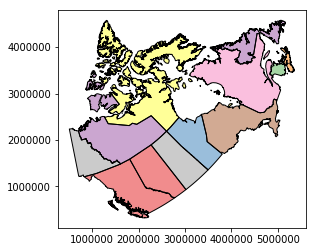

In [6]:
canada.plot(column='NAME')

Save the reprojected version of the file.

In [7]:
# canada.to_file('/Users/jkibele/Documents/SASAP/sasap-size-declines/RiverDistance/data/Canada/Canada_3338.shp')

In [8]:
canada.NAME.unique()

array([u'Quebec', u'Nova Scotia', u'Saskatchewan', u'Alberta',
       u'Newfoundland and Labrador', u'British Columbia', u'New Brunswick',
       u'Prince Edward Island', u'Yukon Territory', u'Manitoba',
       u'Ontario', u'Nunavut', u'Northwest Territories'], dtype=object)

Dissolve the two polygons I'm interested in (the Yukon and BC) into one geometry.

In [9]:
%%time
my_can = ['Yukon Territory', 'British Columbia']
west_can = canada.query("NAME in @my_can").unary_union

CPU times: user 60.9 ms, sys: 4.5 ms, total: 65.4 ms
Wall time: 71.9 ms


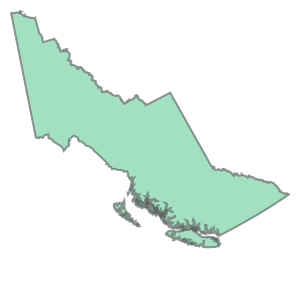

In [10]:
west_can

## Alaska RAP Rivers

I only want the streams that are order 2 or higher.

In [11]:
big_rivs = rivs[rivs.StrOrder >= 2].copy()

This reduces the number of line segements we have to deal with by quite a bit.

In [12]:
len(rivs), len(big_rivs)

(42798, 21171)

Attribute all of the higher order streams with a boolean that indicates if they're in Canada (i.e., within the west Canada geometry).

In [13]:
%%time
big_rivs['in_CA'] = big_rivs.within(west_can)

CPU times: user 36.2 s, sys: 81.1 ms, total: 36.3 s
Wall time: 36.4 s


Get the subset that are in Canada

In [14]:
big_CA_rivs = big_rivs[big_rivs.in_CA].copy()

Plot to make sure we're getting what we expect.

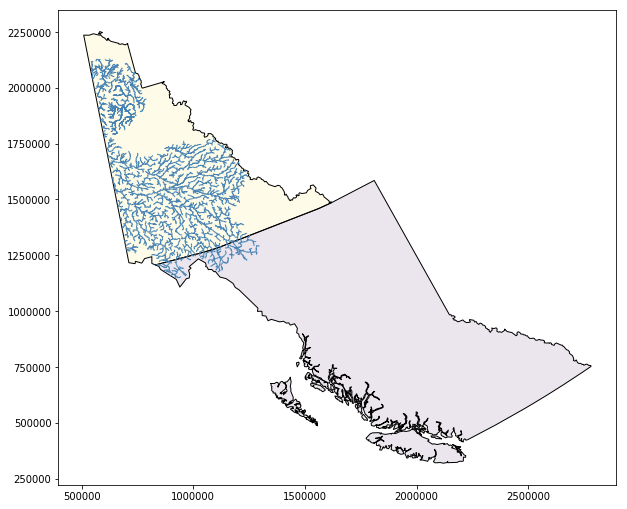

In [15]:
ax = big_CA_rivs.plot(color='steelblue', figsize=(10,10))
canada.query("NAME in @my_can").plot(ax=ax, alpha=0.1)

## BC RAP Rivers

These are a little more complicated because I want to get rid of the extraneous ones that extend down into BC well beyond the SASAP regions.

First, just get rid of the smallest streams.

In [16]:
big_bc_rivs = bc_rap_riv[bc_rap_riv.StrOrder >= 2].copy()

In [17]:
regions = gpd.read_file(sasap_reg_fn)

Simplify the region geometry to speed up processing.

In [18]:
southeast = regions.query("SASAP_Regi=='Southeast'").geometry.simplify(500)

Get the intersection of the Southeast region with Canada.

In [19]:
se_west_can = southeast.intersection(west_can)

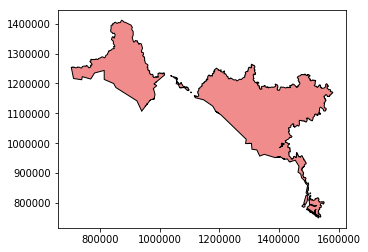

In [20]:
se_west_can.plot()

Attribute the rivers that are in that intersection geometry.

In [21]:
big_bc_rivs['in_CA'] = big_bc_rivs.within(se_west_can.iloc[0])

GeoPandas doesn't have its own concat function for some reason, so I have to concatinate with regular Pandas and then turn it back into a GeoPandas DataFrame.

In [22]:
all_CA_rivs = gpd.GeoDataFrame( pd.concat([big_CA_rivs, big_bc_rivs.query("in_CA == True")]) )

Here's the end result.

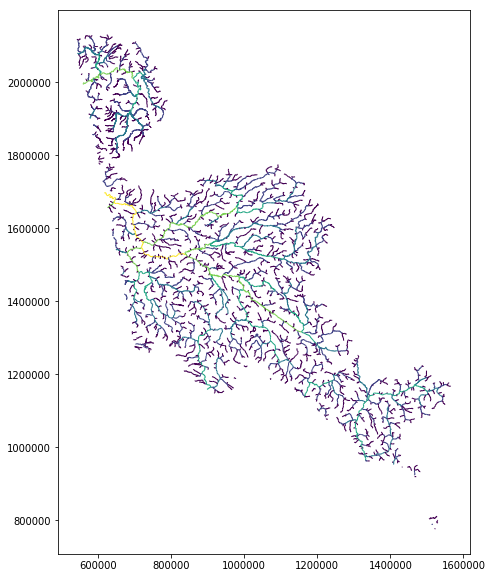

In [23]:
all_CA_rivs.plot(column='StrOrder', figsize=(10,10))

Save it out as a shapefile and make sure it's got the right projection.

In [24]:
outfn = '/Users/jkibele/Documents/SASAP/sasap-size-declines/RiverDistance/data/RAP/SASAP_Canada_DrainlinesSO2.shp'
all_CA_rivs.crs = rivs.crs
all_CA_rivs.drop('in_CA', axis='columns').to_file(outfn)

## All the Rivers in One Shapefile

I guess I want to have the National Map Alaska rivers in there too. That way I can just join them up and be done.

In [24]:
natmapfn = '/Users/jkibele/Documents/SASAP/sasap-size-declines/RiverDistance/data/NatMapGDF.shp'
natmap = gpd.read_file(natmapfn)

In [25]:
natmap.crs

{u'datum': u'NAD83',
 u'lat_0': 50,
 u'lat_1': 55,
 u'lat_2': 65,
 u'lon_0': -154,
 u'no_defs': True,
 u'proj': u'aea',
 u'units': u'm',
 u'x_0': 0,
 u'y_0': 0}

In [36]:
natmap['StrOrder'] = natmap.Strahler

In [37]:
keep_cols = ["StrOrder", "geometry"]

In [38]:
sasap_rivs = gpd.GeoDataFrame( pd.concat([natmap[keep_cols], all_CA_rivs[keep_cols]]) )

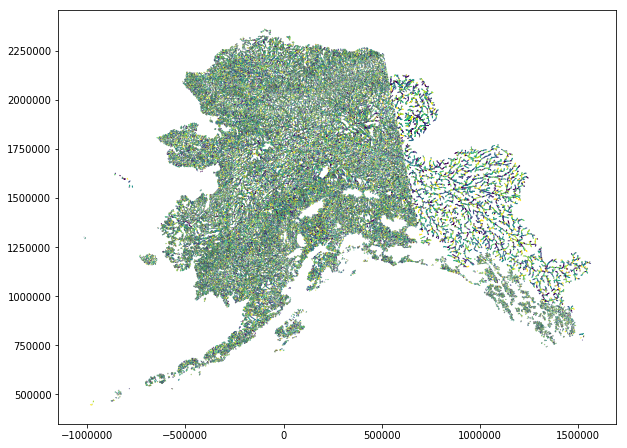

In [34]:
sasap_rivs.plot(figsize=(10,10))

In [39]:
oufn = '/Users/jkibele/Documents/SASAP/sasap-size-declines/RiverDistance/data/sasap_rivs_unconnected.shp'
sasap_rivs.crs = natmap.crs
sasap_rivs.to_file(oufn)

### Connecting the Network

After saving out that file, I went into QGIS and manually created line segments to join the networks across the border. I used vertex snapping, so hopefully everything will line up correctly. I focused on the major rivers. I left a few minor ones disconnected if they had large gaps. That shouldn't matter for our purposes. Here's what I called the file: `/Users/jkibele/Documents/SASAP/sasap-size-declines/RiverDistance/data/sasap_rivs_connected.shp`